# HARDWARE FP MNIST

In [53]:
import torch
import torch.nn.functional as F
from naive_mnistAVGPOOL import NaiveModel
from torchvision import transforms
from torch.utils.data import Dataset
from nni.algorithms.compression.pytorch.quantization import QAT_Quantizer
from nni.compression.pytorch.quantization.settings import set_quant_scheme_dtype
import PIL
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tkinter import *

## FP CLASS

In [71]:
class forward_custom:
  def __init__(self, model, data, batch, num_bits, ifmap,
               ofmap, idim, knl, stride, conv2kernels, maxpool_dim, 
               fc1_nodes, fc2_nodes, non_ideal_file, ncol, nrow, device):
    self.model = model
    self.data = data
    self.batch = batch
    self.num_bits = num_bits
    self.ifmap = ifmap                # Image (grayscale MNIST)
    self.ofmap = ofmap                # Output maps (from applying ofmap knl x knl weight kernels)
    self.idim = idim                  # Input image dimensions
    self.knl = knl                    # Kernel dimensions
    self.stride = stride              # Convolutional stride
    self.conv2kernels = conv2kernels  # Output channels to the second conv layer
    self.maxpool_dim = maxpool_dim    # Maxpool area
    self.fc1_nodes = fc1_nodes        # Fully connected layer 2 output nodes
    self.fc2_nodes = fc2_nodes        # Fully connected layer 2 output nodes
    self.ncol = ncol                  # Hardware matrix-vector-multiplication (MVM) columns (corresponds to number of output ADCs)
    self.nrow = nrow                  # Hardware MVM rows (corresponds to number of input DACs)
                                      # In-memory computing hardware therefore has ncol*nrow weights.

    self.nl_mult = self.read_non_idealities(non_ideal_file)
    self.device = device


  def read_non_idealities(self, file_name):
    return pd.read_excel(file_name, index_col=0).values

  def forward_pass(self):
    # Scale input
    s_in, x = self.scale_quant(self.data, self.num_bits)
    
    # Convolutional layer 1
    x = self.conv2d(x, self.model.conv1.module, s_in, self.idim, self.ifmap, self.ofmap)

    # ReLU 1
    x = self.relu6(x, 0, 6, self.model.relu1.module)

    # Maxpool layer 1
    x = self.avgpool2d(x, self.idim - self.knl + 1, self.ofmap, self.maxpool_dim)
    
    # Scale for convolutional layer 2
    sin_conv2 = self.model.conv2.module.input_scale
    x = self.noscale_quant(x, sin_conv2.cpu(), 0, self.num_bits)
    x = self.conv2d(x, self.model.conv2.module, sin_conv2, (self.idim-self.knl+1)/2, self.ofmap, self.conv2kernels)

    # ReLU 2
    x = self.relu6(x, 0, 6, self.model.relu2.module)

    # Maxpool layer 2
    x = self.avgpool2d(x, ((self.idim - self.knl+1)/2) - self.knl + 1, self.conv2kernels, self.maxpool_dim)

    # Fully connected layer 1
    x = x.view(-1, x.size()[1:].numel())  # Flatten outputs of out_maxpool2 layer to feed to FC layers.
    x = self.fc(x, self.model.fc1.module, self.fc1_nodes)

    # ReLU 3
    x = self.relu6(x, 0, 6, self.model.relu3.module)

    # Fully connected layer 2
    x = self.fc(x.cpu(), self.model.fc2.module, self.fc2_nodes)

    # Softmax layer
    return F.log_softmax(x, dim=1)

  def conv2d(self, x, conv, s_in, idim, ifmap, ofmap):
    # Scale input image, conv weight and bias to bits used
    sw_conv, filters_conv = self.scale_quant(conv.weight.cpu(), self.num_bits)
    bias_conv = conv.bias / (s_in * sw_conv)

    # CONV layer (WSAB dataflow - see convolve2D_wsab function)
    out_conv = self.convolve2D_wsab(x, filters_conv, bias_conv, 0, self.stride, self.batch, ifmap, ofmap, idim, self.knl, self.ncol, self.nrow)
    out_conv = torch.from_numpy(out_conv)
    out_conv = out_conv.to(self.device)

    # Applying scaling normalization s_in*sw_conv (convert back to float)
    return out_conv * s_in * sw_conv


  def convolve2D_wsab(self, image, kernel, bias, padding, strides, batch, ifmap, ofmap, idim, knl, ncol, nrow):
    xKernShape = knl
    yKernShape = knl
    xImgShape = idim
    yImgShape = idim

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((batch, ofmap, xOutput, yOutput))

    # WEIGHT STATIONARY

    # Number of weight block partitions to fit into hardware
    block_col = int(np.ceil(ofmap/ncol))
    block_row = int(np.ceil(knl*knl*ifmap/nrow))
    kernel_flat = np.zeros((block_col*ncol, block_row*nrow), dtype='int64')

    kernel_flat[0:ofmap,0:ifmap*knl*knl] = torch.reshape(kernel, [ofmap, ifmap*knl*knl]).cpu().numpy()
    # data_moved_count = 0
    # mac_completed_count = 0
    # batch = 1
    # Process image by image
    for b in range(batch):
      # Apply Equal Padding to All Sides
      if padding != 0:
          imagePadded = np.zeros((idim + padding * 2, idim + padding * 2))
          imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image[b]
      else:
          imagePadded = image[b]

      # Iterate through image

      image_block = np.zeros((block_row * nrow, xOutput, yOutput), dtype='int64')
      otemp = torch.zeros(block_row, block_col*ncol, xOutput, yOutput)
      for bc in range(block_col):
          for br in range(block_row):
              # data_moved_count += nrow*ncol
              ktemp = torch.zeros(ncol,nrow)
              ktemp = kernel_flat[ncol*bc:(bc+1)*ncol, nrow*br:(br+1)*nrow]
              ktemp = torch.from_numpy(ktemp)

              for y in range(yOutput):
                  for x in range(xOutput):
                      # Fetch image section x,y, bc,br
                      image_block[0:knl * knl * ifmap, x, y] = imagePadded[0:ifmap,
                                                                strides * x: strides * x + xKernShape,
                                                                strides * y: strides * y + yKernShape].reshape(
                          knl * knl * ifmap).cpu().numpy()
                      # data_moved_count += xKernShape*yKernShape
                      # mac_completed_count += ncol
                      # data_moved_count += nrow + 1

                      itemp = image_block[br*nrow:(br+1)*nrow, x, y].reshape(1, nrow)
                      itemp = torch.from_numpy(itemp)
                      # Replace this line with Arduino SPI function call
                      #otemp[br, bc*ncol:(bc+1)*ncol, x, y] = torch.sum(ktemp*itemp, dim=1)
                      otemp[br, bc*ncol:(bc+1)*ncol, x, y] = self.non_linear_mult(ktemp, itemp[0])
                      # print("Batch:%d,BROW:%d,BCOL:%d,X:%d,Y:%d" % (b,br,bc,x,y))

      output[b] = torch.sum(otemp[:, 0:ofmap, :, :], dim=0) + (bias.reshape(ofmap, 1, 1).cpu()*torch.ones(xOutput, yOutput)).detach().numpy()

    # print(f"Moved {data_moved_count} pieces of data, {mac_completed_count} MAC operations completed")
    # print(ktemp[1000])  # Workaround breakpoint

    # # OUTPUT STATIONARY
    # # Number of output block partitions to fit into hardware
    # block_col = int(np.ceil(xOutput/ncol))
    # block_row = int(np.ceil(knl*knl*ifmap/nrow))

    # kernel_flat = np.zeros((block_col*ncol, block_row*nrow))
    # kernel_flat[0:ofmap,0:ifmap*knl*knl] = torch.reshape(kernel, [ofmap, ifmap*knl*knl]).cpu().numpy()

    # data_moved_count = 0
    # mac_completed_count = 0
    # batch = 1

    # # Process image by image
    # for b in range(batch):
    #   # Apply Equal Padding to All Sides
    #   if padding != 0:
    #       imagePadded = np.zeros((idim + padding * 2, idim + padding * 2))
    #       imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image[b]
    #   else:
    #       imagePadded = image[b]

    #   image_block = np.zeros((nrow * block_row, ncol*block_col, yOutput))
    #   otemp = torch.zeros((nrow * block_row, ofmap, ncol*block_col, yOutput))

    #   for y in range(yOutput):
    #      for x in range(xOutput):
    #         image_block[0:knl * knl * ifmap, x, y] = imagePadded[0:ifmap,
    #                                                       strides * x: strides * x + xKernShape,
    #                                                       strides * y: strides * y + yKernShape].reshape(
    #                 knl * knl * ifmap).cpu().numpy()

    #   # Iterate through image
    #   for y in range(yOutput):
    #       for bc in range(block_col):
    #         for br in range(block_row):
    #           data_moved_count += nrow*ncol
    #           for kerCol in range(ofmap):
    #             data_moved_count += nrow
    #             ktemp = kernel_flat[kerCol, br*nrow:(br+1)*nrow]
    #             ktemp = torch.from_numpy(ktemp)
    #             for x in range(ncol):
    #                 mac_completed_count += 1
    #                 data_moved_count += 1
    #                 # Fetch image section x,y, bc,br
    #                 itemp = image_block[br*nrow:(br+1)*nrow, (bc*ncol)+x, y].reshape(1, nrow)
    #                 itemp = torch.from_numpy(itemp)
    #                 # Replace this line with Arduino SPI function call
    #                 otemp[br, kerCol, (bc*ncol)+x, y] = torch.sum(ktemp*itemp, dim=1)
    #                 # otemp[kerCol, x, y] = self.non_linear_mult(ktemp, itemp[0])
    #                 # print("Batch:%d,BROW:%d,BCOL:%d,X:%d,Y:%d" % (b,br,bc,x,y))
    #   output[b] = torch.sum(otemp[0:block_row, 0:ofmap, 0:xOutput, 0:yOutput], dim=0) + (bias.reshape(ofmap, 1, 1).cpu()*torch.ones(xOutput, yOutput)).detach().numpy()
    #   print(f"Moved {data_moved_count} pieces of data, {mac_completed_count} MAC operations completed")
    #   print(ktemp[1000]) # Workaround breakpoint

    return output


  def relu6(self, x, min_val, max_val, relu_module):
    i = (x >= min_val) * x
    out_relu = (i <= max_val) * (i - max_val) + max_val
    so_relu = relu_module.output_scale

    # Apply fake quantization to relu1 output.
    out_relu = self.noscale_quant(out_relu, so_relu, 0, self.num_bits)
    return self.dequantize(out_relu, so_relu, 0)


  def maxpool2d(self, x, idim, ofmap, knl):
    # Maxpool layer - downsample by knl x knl with maxpool (no quantization required for max function)
    return torch.from_numpy(self.maxpool2D_wsa(self.batch, x, idim, ofmap, knl))


  # Maxpool layer (apply to all ofmaps simultaneously - faster!)
  def maxpool2D_wsa(self, batch, image, idim, ofmap, knl):
    xKernShape = knl
    yKernShape = knl
    xImgShape = idim
    yImgShape = idim
    strides = knl
    padding = 0
    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((batch, ofmap, xOutput, yOutput))

    for b in range(batch):
        # Apply Equal Padding to All Sides
        if padding != 0:
            imagePadded = np.zeros((idim + padding * 2, idim + padding * 2))
            imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image[b]
        else:
            imagePadded = image[b]

        # Iterate through image
        for y in range(yOutput):
            for x in range(xOutput):
                output[b, :, x, y] = torch.amax(
                        imagePadded[:, strides * x: strides * x + xKernShape, strides * y: strides * y + yKernShape], dim=(1,2)).detach().cpu().numpy()
    return output
  

  def avgpool2d(self, x, idim, ofmap, knl):
    # Maxpool layer - downsample by knl x knl with maxpool (no quantization required for max function)
    return torch.from_numpy(self.avgpool2D_wsa(self.batch, x, idim, ofmap, knl))
  

  # Maxpool layer (apply to all ofmaps simultaneously - faster!)
  def avgpool2D_wsa(self, batch, image, idim, ofmap, knl):
    xKernShape = knl
    yKernShape = knl
    xImgShape = idim
    yImgShape = idim
    strides = knl
    padding = 0
    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((batch, ofmap, xOutput, yOutput))

    for b in range(batch):
        # Apply Equal Padding to All Sides
        if padding != 0:
            imagePadded = np.zeros((idim + padding * 2, idim + padding * 2))
            imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image[b]
        else:
            imagePadded = image[b]

        # Iterate through image
        for y in range(yOutput):
            for x in range(xOutput):
                for channel in range(ofmap):
                  # output[b, channel, x, y] = torch.sum(
                  #    imagePadded[channel, strides * x: strides * x + xKernShape, strides * y: strides * y + yKernShape].reshape(knl*knl) 
                  #    * torch.ones(xKernShape*yKernShape), dim=0)/(knl*knl)
                  output[b, channel, x, y] = self.non_linear_mult(
                        imagePadded[channel, strides * x: strides * x + xKernShape, strides * y: strides * y + yKernShape].reshape(knl*knl),
                        torch.ones(xKernShape*yKernShape))/(knl*knl)
    return output


  def fc(self, x, module, odim):
    sin_fc = module.input_scale.cpu()
    in_fcs = self.noscale_quant(x, sin_fc, 0, self.num_bits)
    sw_fc, filters_fc = self.scale_quant(module.weight.cpu(), self.num_bits)
    bias_fc = module.bias.cpu() / (sw_fc * sin_fc)


    # FC layer using (WSA dataflow)
    # N.B. Need to implement WSAB function to implement 'hardware acceleration' of FC layer.
    out_fc = torch.from_numpy(self.fc_custom_wsab(in_fcs, filters_fc, bias_fc, self.batch, odim, self.ncol, self.nrow))

    # FC output scaling
    out_fcs = out_fc * sin_fc * sw_fc

    so_fc = module.output_scale.cpu()
    # FC output fake quantization
    return self.dequantize(self.noscale_quant(out_fcs, so_fc, 0, self.num_bits), so_fc, 0).to(self.device)


  # 'Fake' Quantization function [Jacob et. al]
  def quantize(self, real_value, scale, zero_point, qmin, qmax):
    transformed_val = zero_point + real_value / scale
    clamped_val = torch.clamp(transformed_val, qmin, qmax)
    quantized_val = torch.round(clamped_val)
    return quantized_val


  # 'Fake' Dequantization function [Jacob et. al]
  def dequantize(self, quantized_val, scale, zero_point):
    real_val = scale * (quantized_val - zero_point)
    return real_val


  # Scaling function (Jacob et. al)
  def scale_quant(self, real_value, num_bits):
    qmin = -(2 ** (num_bits - 1) - 1)
    qmax = 2 ** (num_bits - 1) - 1
    abs_max = torch.abs(real_value).max()
    scale = abs_max / (float(qmax - qmin) / 2)
    zero_point = 0
    quant = self.quantize(real_value, scale, zero_point, qmin, qmax)
    return scale, quant


  # Scaling function (Jacob et. al)
  def noscale_quant(self, real_value, scale, zero_point, num_bits):
    qmin = -(2 ** (num_bits - 1) - 1)
    qmax = 2 ** (num_bits - 1) - 1
    quant = self.quantize(real_value, scale, zero_point, qmin, qmax)
    return quant


  # Custom FC layer (vector multiplication style - much faster than for loop implementation)
  def fc_custom_wsa(self, fc_input, filters, bias, batch, ofmap):
    print(fc_input.size()[1])
    print(fc_input)
    output = np.zeros((batch, ofmap))
    for b in range(batch):
        outputi = np.zeros(ofmap)
        input_batch = fc_input[b]
        print((input_batch*filters).size())
        outputi = torch.sum((input_batch * filters),dim=1) + bias
        output[b, :] = outputi.detach().numpy()
    return output
  
  
  def fc_custom_wsab(self, fc_input, filters, bias, batch, ofmap, ncol, nrow):
    output = np.zeros((batch, ofmap))
    for b in range(batch):
        # WEIGHT STATIONARY

        # Iterate through image
        block_col = int(np.ceil(ofmap/ncol))
        block_row = int(np.ceil(fc_input.size()[1]/nrow))
        filters_flat = np.zeros((block_col*ncol, block_row*nrow), dtype='int64')
        image_col = np.zeros((block_row*nrow), dtype='int64')

        filters_flat[0:ofmap,0:fc_input.size()[1]] = torch.reshape(filters, [ofmap, fc_input.size()[1]]).cpu().numpy()
        image_col[0:fc_input.size()[1]] = fc_input[b, :]

        otemp = torch.zeros(block_row, block_col*ncol)

        for bc in range(block_col):
            for br in range(block_row):
                ftemp = torch.zeros(ncol,nrow)
                ftemp = filters_flat[ncol*bc:(bc+1)*ncol, nrow*br:(br+1)*nrow]
                ftemp = torch.from_numpy(ftemp)

                itemp = image_col[br*nrow:(br+1)*nrow].reshape(1, nrow)
                itemp = torch.from_numpy(itemp)

                for col in range(ncol):
                  # Replace this line with Arduino SPI function call
                  otemp[br, (bc*ncol)+col] = torch.sum(ftemp[col, :]*itemp[0], dim=0)
                  #otemp[br, (bc*ncol)+col] = self.non_linear_mult(ftemp[col, :], itemp[0])
                  # print("Batch:%d,BROW:%d,BCOL:%d,X:%d,Y:%d" % (b,br,bc,x,y))
        output[b] = torch.sum(otemp[:, 0:ofmap], dim=0) + (bias.reshape(ofmap).cpu()*torch.ones(ofmap)).detach().numpy()
    return output


  # Non-linear look-up
  def non_linear_conv(self, kernel, image):
    sum = 0
    if self.num_bits == 9 or self.num_bits == 8:
       bit = 9
    else:
       bit = 5
    for i in range(len(kernel)):
      sum = sum + self.nl_mult[int(kernel[i]+(2**(bit-1))-1)][int(image[i]+(2**(bit-1))-1)]
      #sum = sum + (kernel[i]*image[i] + 20*kernel[i]*np.sin(np.pi*kernel[i]/5)*np.sin(np.pi*image[i]/5))
    return sum

  def non_linear_mult(self, kernel, image):
    output = np.empty(len(kernel))
    if len(kernel.shape) == 2:
      for i in range(len(kernel)):
        output[i] = self.non_linear_conv(kernel[i, :].tolist(), image.tolist())
      return torch.from_numpy(output)
    else:
      output = self.non_linear_conv(kernel.tolist(), image.tolist())
      return output
    

In [55]:
# Kernel dimensions (used in conv layers)
knl = 5

# Kernel stride
stride = 1

# Output Feature Maps (same as kernels in conv layer 1)
ofmap = 16

# Kernels in conv layer 2
conv2kernels = 32

# Maxpool dimensions (assuming square area)
maxpool_dim = 2

# Fully Connected 1 output nodes
fc1_nodes = 50

# Hardware MVM columns
ncol = 16

# Hardware MVM rows
nrow = 32

# Non-Idealities File
non_ideal_file = '../HardwareSpec/4x4_Mac_result_final.xlsx'

In [56]:
def capture_input():
    width = 300  # canvas width
    height = 300 # canvas height
    black = (0, 0, 0) # canvas back

    def save_and_exit():
        # save image to hard drive
        filename = "data/user_input.jpg"
        output_image.save(filename)
        master.destroy()

    def paint(event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        canvas.create_oval(x1, y1, x2, y2, fill="white",width=40)
        draw.line([x1, y1, x2, y2],fill="white",width=40)

    master = Tk()

    # create a tkinter canvas to draw on
    canvas = Canvas(master, width=width, height=height, bg='black')
    canvas.pack()

    # create an empty PIL image and draw object to draw on
    output_image = PIL.Image.new("RGB", (width, height), black)
    draw = PIL.ImageDraw.Draw(output_image)
    canvas.pack(expand=YES, fill=BOTH)
    canvas.bind("<B1-Motion>", paint)

    # add a button to save the image
    button=Button(text="save",command=save_and_exit)
    button.pack()

    master.mainloop()

In [57]:
def setup_CNN():
    torch.set_default_dtype(torch.float32)
    torch.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # INT9 weight, INT9 activations
    num_bits = 4
    # Make sure this matches quantization config from MNIST_CNN_Training
    configure_list = [{
        'quant_types': ['weight', 'input'],
        'quant_bits': {'weight': num_bits, 'input': num_bits},
        'quant_start_step': 2,
        'op_names': ['conv1', 'conv2']
    }, {
        'quant_types': ['output'],
        'quant_bits': {'output': num_bits},
        'quant_start_step': 2,
        'op_names': ['relu1', 'relu2', 'relu3']
    }, {
        'quant_types': ['output', 'weight', 'input'],
        'quant_bits': {'output': num_bits, 'weight': num_bits, 'input': num_bits},
        'quant_start_step': 2,
        'op_names': ['fc1', 'fc2'],
    }]

    set_quant_scheme_dtype('weight', 'per_tensor_symmetric', 'int')
    set_quant_scheme_dtype('output', 'per_tensor_symmetric', 'int')
    set_quant_scheme_dtype('input', 'per_tensor_symmetric', 'int')


    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    user_image = PIL.Image.open('data/user_input.jpg')
    user_image = user_image.resize((28,28), PIL.Image.LANCZOS).convert('L')
    tensor_image = transform(user_image)

    #tensor_image = transform(PIL.Image.open('data/eight.jpg'))

    idim = tensor_image.size()[1]
    ifmap = tensor_image.size()[0]
    fc2_nodes = 10

    # Create a NaiveModel object and apply QAT_Quantizer setup
    model_path = "models/mnist_model_4bit_AVGPOOL.pth"
    qmodel = NaiveModel().to(device)
    optimizer = torch.optim.SGD(qmodel.parameters(), lr=0.01, momentum=0.5)

    dummy_input = torch.randn(1, ifmap, idim, idim).to(device)
    # To enable batch normalization folding in the training process, you should
    # pass dummy_input to the QAT_Quantizer.
    quantizer = QAT_Quantizer(qmodel, configure_list, optimizer, dummy_input=dummy_input)
    quantizer.compress()


    # Load trained model (from MNIST_CNN_Training step).
    state = torch.load(model_path, map_location=device)
    qmodel.load_state_dict(state, strict=True)
    qmodel.eval()
    return tensor_image, device, qmodel, num_bits, ifmap, idim, fc2_nodes

Number written is 5


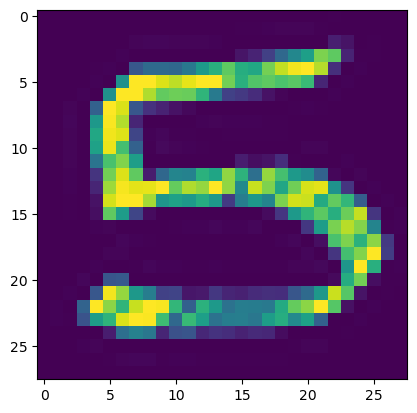

In [72]:
capture_input()
tensor_image, device, model, num_bits, ifmap, idim, fc2_nodes = setup_CNN()
plt.imshow(tensor_image.permute(1, 2, 0))

with torch.no_grad():
        data = tensor_image.unsqueeze(0)
        data = data.to(device)
        batch = 1

        # Custom forward pass function
        non_linear_model = forward_custom(model, data, batch, num_bits, ifmap, ofmap, idim, knl, stride, conv2kernels,
                                            maxpool_dim, fc1_nodes, fc2_nodes, non_ideal_file, ncol, nrow, device)
        output = non_linear_model.forward_pass()
        pred = output.argmax(dim=1, keepdim=True)[0][0]
        print(f"Number written is {pred}")
